<a href="https://colab.research.google.com/github/ChamodKalupahana/simulating_the_universe_using_GANs/blob/main/Plotting_novel_N_body_generation_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample N-body map vs generated maps

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Mounted at /content/drive


### Load data

In [ ]:
N_body_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'

N_body_dataset = np.arcsinh(np.load(N_body_field_file_path_IllustrisTNG))
N_body_dataset = np.expand_dims((N_body_dataset) - np.mean(N_body_dataset), axis=3)

generated_images = np.load('/content/drive/MyDrive/Colab Notebooks/Results/novel_cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_N-body_predictions_1000_images.npy')

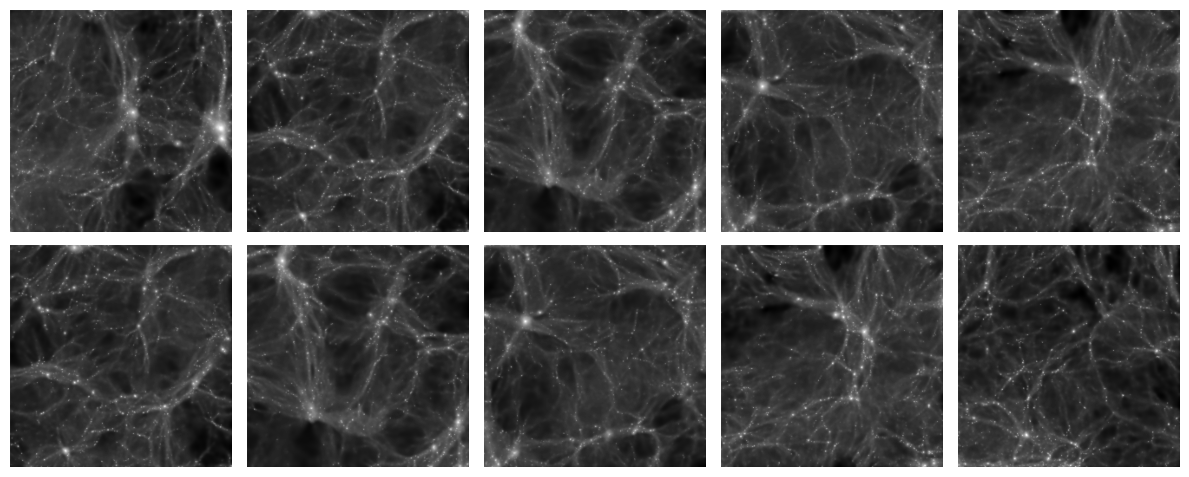

In [ ]:
rows = 2
columns = 5

fig, ax = plt.subplots(rows, columns, figsize=(12,5))

for column in range(columns):
  for row in range(rows):
    ax[row, column].imshow(generated_images[column + row], cmap='gray')
    ax[row, column].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/Novel_N_body_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_sample_10_images.jpg', dpi=1000)

# Plotting power strecpa for novel Diffusion vs N-body

### Import modules

In [ ]:
# !pip install google-colab-auth
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
# from google.colab import auth
# auth.authenticate_user()


Mounted at /content/drive


### Load data

In [ ]:
n_body_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images.npy'

RU_net_novel_diffusion_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/novel_cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_N-body_predictions_1000_images.npy'

number_of_images = 1000

ds_nbody = np.load(n_body_file_path)
ds_nbody = np.squeeze(ds_nbody[0:number_of_images])

RU_net_novel_diffusion_ds_Mz_predictions = np.load(RU_net_novel_diffusion_predictions_file_path)
RU_net_novel_diffusion_ds_Mz_predictions = np.squeeze(RU_net_novel_diffusion_ds_Mz_predictions[0:number_of_images], axis=-1)

Nx = ds_nbody.shape[-1] # 256, since ds_Mz_truth has shape (100, 256, 256)
kvals = np.arange(0, Nx / 2)

Text(0.5, 1.0, 'RU-net novel diffusion predictions')

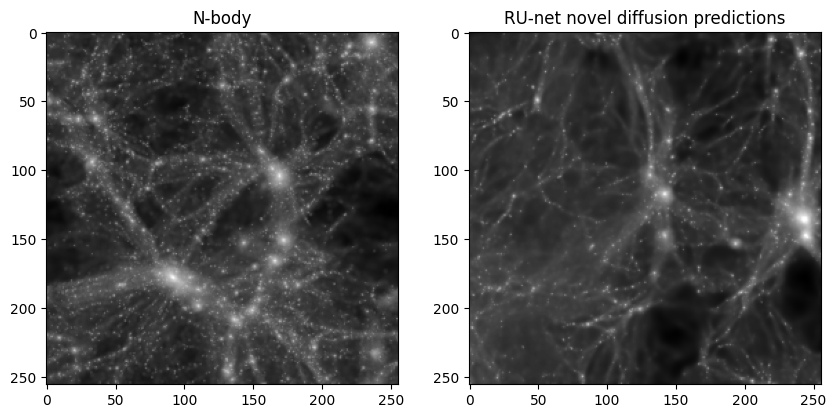

In [ ]:
# check data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(ds_nbody[0], cmap='gray')
ax[1].imshow(RU_net_novel_diffusion_ds_Mz_predictions[0], cmap='gray')

ax[0].set_title('N-body')
ax[1].set_title('RU-net novel diffusion predictions')

In [ ]:
!pip install quantimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 94.4 MB/s eta 0:00:00


### Plot figure

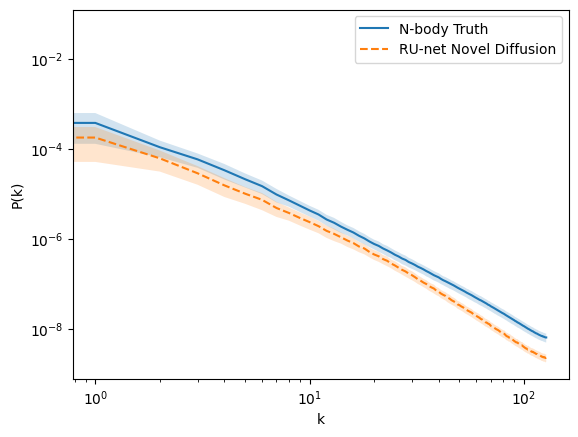

In [ ]:
# Code from GitHub

from quantimpy import minkowski as mk

# def calc_1dps_img2d(img, smoothed=0.5):
#     img = np.squeeze(img)
#     Nx = img.shape[0]
#     kvals = np.arange(0, Nx / 2)
#     fft_zerocenter = np.fft.fftshift(np.fft.fft2(img) / Nx ** 2)
#     impf = abs(fft_zerocenter) ** 2.0
#     x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
#     R = np.sqrt((x - (Nx / 2)) ** 2 + (y - (Nx / 2)) ** 2)
#     filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
#     mean = np.vectorize(filt)(kvals)
#     return kvals, mean
 
def calc_1dps_img2d(kvals, img, smoothed=0.5):
    """Compute the power spectrum of a single input image"""
    # print("calc_1dps input image shape is: ", img.shape)
    Nx = img.shape[0]
    # print("Nx is ", Nx)
    fft_zerocenter = np.fft.fftshift(np.fft.fft2(img)/Nx**2) #Aug
    impf = abs(fft_zerocenter) ** 2.0
    x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
    R  = np.sqrt((x-(Nx/2))**2+(y-(Nx/2))**2) #Aug
    filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
    mean = np.vectorize(filt)(kvals)
    return mean


def get_minkowski(img, min=-1, max=1):
    img = np.squeeze(img)
    gs_vals = np.linspace(min, max, 50)
    gs_masks = [img >= gs_vals[ig] for ig in range(len(gs_vals))]
    minkowski = []
    for i in range(len(gs_masks)):
        minkowski.append(mk.functionals(gs_masks[i], norm=True))
    return np.vstack(minkowski)


# def populate_samplist(img_list_a, img_list_b):
#   """Populates a samplist array with N image power spectra"""
#     samplist = []
#     Nx = img_list[0].shape[0]
#     kvals = np.arange(0, Nx / 2)
#     for img in img_list:
#       spec = calc_1dps_img2d(kvals, img)
#       samplist.append(spec)

#     return samplist


# samplist = populate_samplist(ds_truth[0:100]) # power spectra of 100 images in ds_truth


def get_powspec_for_samples(samplist):
    ps_list = []
    Nx = samplist[0].shape[-1] # Nx=256
    kvals = np.arange(0, Nx/2)
    # print("samplist shape is: ",samplist.shape)
    for samp in samplist:
        assert len(samp.shape)==3
        assert samp.shape[-1]==Nx
        assert samp.shape[-2]==Nx
        # print("samp shape is: ", samp.shape)
        pssamp = np.vstack([calc_1dps_img2d(kvals, samp[ci, ...], smoothed=0.25) for ci in range(samp.shape[0])])
        ps_list.append(pssamp)
    return ps_list # removed the return of kvals

# cols=['b', 'r']
def plot_ps_samples(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='solid' if isd==0 else 'dashed'
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'k')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'P(k)')
    plt.legend()
    # plt.show()
    return

def plot_ps_samples_M_Z_data(kvals, samplist, names, logscale=True, k2pk=False):
    #plt.figure(figsize=[6, 6])
    for isd, samp in enumerate(samplist):
        assert len(samp.shape)==2
        if k2pk:
            samp = samp*(kvals**2)
        meanps = np.mean(samp, axis=0)
        stdps = np.std(samp, axis=0, ddof=1)
        # print(len(kvals) == len(meanps))
        # print("kvals is ",kvals )
        # print("meanps is ",meanps)
        # print("stdps is ",stdps)
        style='dashed' # changed from M_Z_truth function
        # c=cols[isd]
        plt.plot(kvals, meanps, label=names[isd], linestyle=style)
        # color=cols[isd]
        plt.fill_between(kvals, meanps-stdps, meanps+stdps, alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    plt.xlabel(r'Spatial frequency (k)')
    if k2pk:
        plt.ylabel(r'$k^2P(k)$')
    else:
        plt.ylabel(r'Power Spectrum  P(k)')
    plt.legend()
    # plt.show()
    return


RUnet_Mz_samplist = np.stack((ds_nbody, RU_net_novel_diffusion_ds_Mz_predictions)) # list of two (100, 256, 256) samples
RU_net_ps_list = get_powspec_for_samples(RUnet_Mz_samplist)
plot_ps_samples(kvals, RU_net_ps_list, names=["N-body Truth", "RU-net Novel Diffusion"])

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/Novel Diffusion vs N-body truth Power spectrum 1000 images.jpg', dpi=1000)
plt.show()